In [111]:
import numpy as np
import matplotlib.pyplot as plt
from inference_interface import multihist_to_template, template_to_multihist
from multihist import Histdd, Hist1d

In [33]:
from alea.ces_source import CESTemplateSource
from alea.template_source import TemplateSource
from alea.utils import load_yaml
from alea.utils import get_file_path

In [253]:
import multihist as mh
HAVE_MULTIHIST = True
def template_to_multihist(file_name, hist_name=None, hist_to_read=Histdd):
    """
    Function that loads a template into the Hist1d or Histdd format
    :param file_name: name of template file
    :param hist_name: name of template, if None, return a dict indexed by histogram names containing the histograms
    """
    if not HAVE_MULTIHIST:
        raise NotImplementedError("template_to_multihist requires multihist")
    
    with h5py.File(file_name, "r") as f:
        if hist_name is None:
            ret = dict()
            for hist_name in f["templates"]:
                if hist_to_read == Hist1d:
                    # for 1d case, flatten the bins
                    bins = np.array(f["bins/0"])
                    print(bins)
                    h = mh.Hist1d.from_histogram(np.array(f["templates/" + hist_name]), bins)
                else:
                    bins = [np.array(f[f"bins/{i}"]) for i in range(len(f["bins"]))]
                    bin_names = [f[f"bins/{i}"].attrs.get("name", f"axis{i}") for i in range(len(f["bins"]))]
                    h = mh.Histdd(bins=bins, axis_names=bin_names)
                    h.histogram = np.array(f["templates/" + hist_name])
                ret[hist_name] = h
        else:
            bins = [np.array(f[f"bins/{i}"]) for i in range(len(f["bins"]))]
            if len(bins) == 1:
                ret = mh.Hist1d.from_histogram(np.array(f["templates/" + hist_name]), bins[0])
            else:
                bin_names = [f[f"bins/{i}"].attrs.get("name", f"axis{i}") for i in range(len(f["bins"]))]
                ret = mh.Histdd(bins=bins, axis_names=bin_names)
                ret.histogram = np.array(f["templates/" + hist_name])

    return ret

def multihist_to_template(
        histograms, file_name,
        histogram_names=None,
        hist_to_store = Histdd,
        metadata={"version":"0.0","date":datetime.now().strftime('%Y%m%d_%H:%M:%S')}):
    if not HAVE_MULTIHIST:
        raise NotImplementedError("template_to_multihist requires multihist")
    if histogram_names is None:
        histogram_names = ["%i" for i in range(len(histograms))]
    with h5py.File(file_name, "w") as f:
        for k, i in metadata.items():
            f.attrs[k] = i
        bins = histograms[0].bin_edges
        axis_names = histograms[0].axis_names
        if hist_to_store == Hist1d:
            dset = f.create_dataset("bins/0", data=bins)
        else:
            if axis_names is None:
                axis_names = ["" for i in range(len(bins))]
            for i, (b, bn) in enumerate(zip(bins, axis_names)):
                dset = f.create_dataset("bins/{:d}".format(i), data=b)
                dset.attrs["name"] = bn

        for histogram, histogram_name in zip(histograms, histogram_names):
            dset = f.create_dataset(
                "templates/{:s}".format(histogram_name), data=histogram.histogram)


In [247]:
xe133_path = get_file_path("xe133_ces.pkl")

In [248]:
# load the ces data in the .pkl file
import pickle
with open(xe133_path, 'rb') as f:
    xe133_data = pickle.load(f)

In [260]:
!rm xe133_template.ii.h5
multihist_to_template(histograms = [xe133_data], hist_to_store=Hist1d,
                      histogram_names  = ["xe133_template"],
                      file_name = "xe133_template.ii.h5")

In [261]:
# see the format of example data
xe133_file = get_file_path("xe133_template.ii.h5")

In [262]:
xe133_hist = template_to_multihist(xe133_file, hist_name=None, hist_to_read=Hist1d)

[0.000e+00 1.000e+00 2.000e+00 ... 2.998e+03 2.999e+03 3.000e+03]


In [263]:
wimp_hist = template_to_hist(wimp_file, hist_name=None, hist_to_read=Histdd)

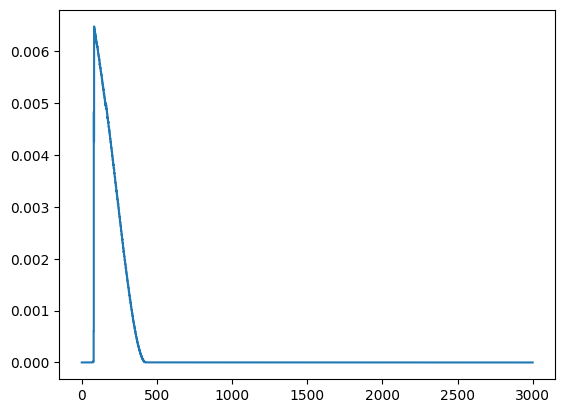

In [266]:
xe133_hist["xe133_template"].plot()